## Import data and set up parameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from utils import *
import torch
from torch import nn
torch.use_deterministic_algorithms(True)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from captum.attr import FeaturePermutation
import sys
import random
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

sys.path.append('../configs/')
default_configfile = 'splby-random_val-True_phyinf-False_bayopt-False_pro-OptiMat_pat-500_epo-2000_lr-003_weidec-002_batsiz-1024_ncal-200'

if is_notebook():
    args = load_config(default_configfile)
else:
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--configfile', default=default_configfile)

    args = load_config(parser.parse_args().configfile)

split_by = args['split_by']  # 'random' or 'material'

validation = args['validation']
physics_informed = args['physics_informed']
bayes_opt = args['bayes_opt']

project = args['project']

data_path = f'../data/{project}_fatigue.xlsx'
ckp_path = f'../output/{project}/fatigue.pt'
skopt_path = f'../output/{project}/skopt.pt'

static_params = args['static_params']
chosen_params = args['chosen_params']
layers = args['layers']
n_calls = args['n_calls']
SPACE = args['SPACE']

if physics_informed:
    loss_fn = PI_MSELoss()
else:
    loss_fn = nn.MSELoss()

Using cpu device


## Set datasets

In [2]:
data = pd.read_excel(data_path, engine='openpyxl')

feature_names = list(args['feature_names_type'].keys())

label_name = args['label_name']

feature_data, label_data, X, y, train_dataset, val_dataset, test_dataset, scaler = split_dataset(data, feature_names, label_name, device, validation, split_by)

Dataset size: 542 180 182


## Gaussian process-based Bayes hyperparameter optimization (Optional)

In [3]:
if bayes_opt:
    bar = tqdm(total=n_calls)

    @skopt.utils.use_named_args(SPACE)
    def objective(**params):
        res = model_train(train_dataset, test_dataset, val_dataset, layers, validation, loss_fn, ckp_path, device,
                          verbose=False, return_loss_list=False, **{**params, **static_params})

        return res

    postfix = {'Current loss': 1e8, 'Minimum': 1e8, 'Params': list(chosen_params.values()), 'Minimum at call': 0}

    def callback(result):
        postfix['Current loss'] = result.func_vals[-1]

        if result.fun < postfix['Minimum']:
            postfix['Minimum'] = result.fun
            postfix['Params'] = result.x
            postfix['Minimum at call'] = len(result.func_vals)
        skopt.dump(result, skopt_path)

        if len(result.func_vals) % 5 == 0:
            plt.figure()
            ax = plt.subplot(111)
            ax = plot_convergence(result, ax)
            plt.savefig(f'../output/{project}/skopt_convergence.svg')
            plt.close()

        bar.set_postfix(**postfix)
        bar.update(1)

    result = gp_minimize(objective, SPACE, n_calls=n_calls, random_state=0, x0=list(chosen_params.values()),
                         callback=callback)
    print(result.func_vals.min())

    params = {}
    for key,value in zip(chosen_params.keys(), result.x):
        params[key] = value

    print(params)

else:
    params = chosen_params

## Training

In [4]:
model = NN(len(feature_names),len(label_name), layers).to(device)

min_loss,train_ls,val_ls = model_train(train_dataset, test_dataset, val_dataset, layers, validation, loss_fn, ckp_path, device, model = model, verbose_per_epoch=100, **{**params, **static_params})

if validation:
    model.load_state_dict(torch.load(ckp_path))
else:
    torch.save(model.state_dict(), ckp_path)

print('Minimum loss:', min_loss)

Epoch: 1/2000, Train loss: 19.0494, Val loss: 8.9932
Epoch: 100/2000, Train loss: 0.5484, Val loss: 0.5911
Epoch: 200/2000, Train loss: 0.3902, Val loss: 0.5045
Epoch: 300/2000, Train loss: 0.4007, Val loss: 0.5268
Epoch: 400/2000, Train loss: 0.3168, Val loss: 0.4797
Epoch: 500/2000, Train loss: 0.2966, Val loss: 0.4782
Epoch: 600/2000, Train loss: 0.2958, Val loss: 0.4999
Epoch: 700/2000, Train loss: 0.2847, Val loss: 0.5177
Epoch: 800/2000, Train loss: 0.2605, Val loss: 0.4882
Epoch: 900/2000, Train loss: 0.2851, Val loss: 0.5323
Epoch: 1000/2000, Train loss: 0.2592, Val loss: 0.5095
Early stopping at epoch 1027, Checkpoint at epoch 527, Train loss: 0.2989, Val loss: 0.4706
Minimum loss: 0.47057029604911804


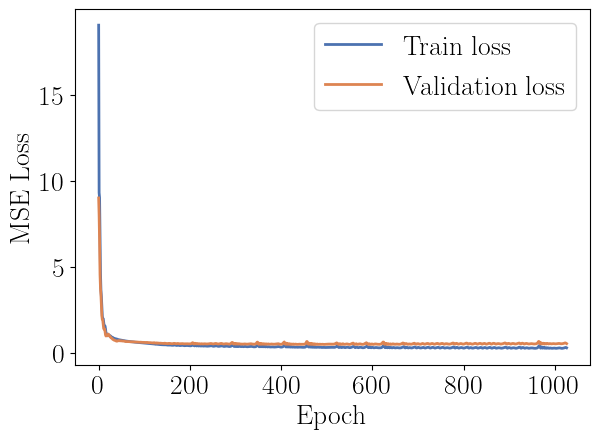

In [5]:
plt.figure()
plt.rcParams['font.size'] = 20
ax = plt.subplot(111)
plot_loss(train_ls, val_ls, ax)
plt.savefig(f'../output/{project}/loss_epoch.svg')
if is_notebook():
    plt.show()
plt.close()

## Plot results and compare NN with baseline models

Train MSE Loss: 0.2900, R2: 0.8056
Validation MSE Loss: 0.4706, R2: 0.6819
Test MSE Loss: 0.5476, R2: 0.6535


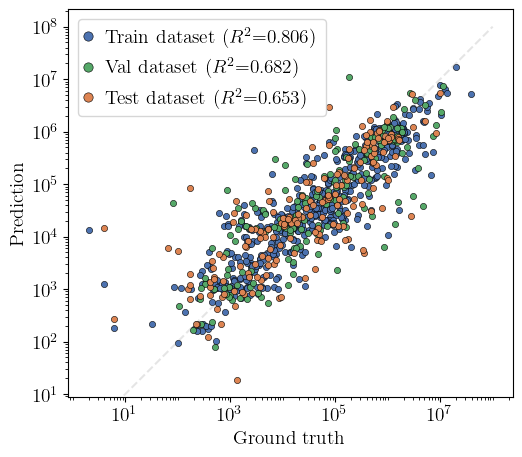

In [6]:
plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)
plot_truth_pred_NN(train_dataset, val_dataset, test_dataset, model, loss_fn, ax)
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig(f'../output/{project}/truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

Train MSE Loss: 0.0824, R2: 0.9448
Test MSE Loss: 0.6129, R2: 0.6122


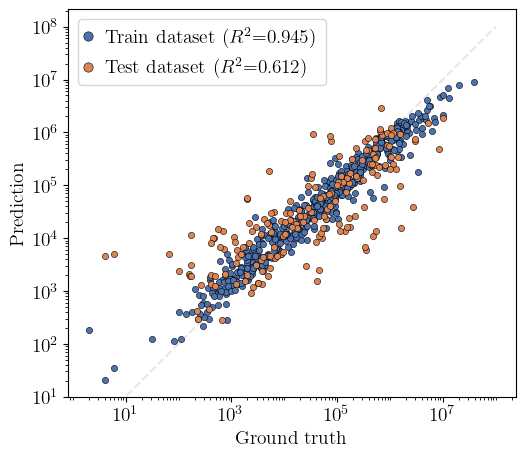

In [7]:
plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

if split_by == 'material':
    rf = RandomForestRegressor(n_jobs=-1, max_depth=6)
else:
    rf = RandomForestRegressor(n_jobs=-1, max_depth=15)

plot_truth_pred_sklearn(feature_data, label_data, train_dataset.indices, test_dataset.indices, ax, model = rf, split_by = split_by)
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig(f'../output/{project}/rf_truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

Train MSE Loss: 1.0746, R2: 0.2798
Test MSE Loss: 1.1446, R2: 0.2757


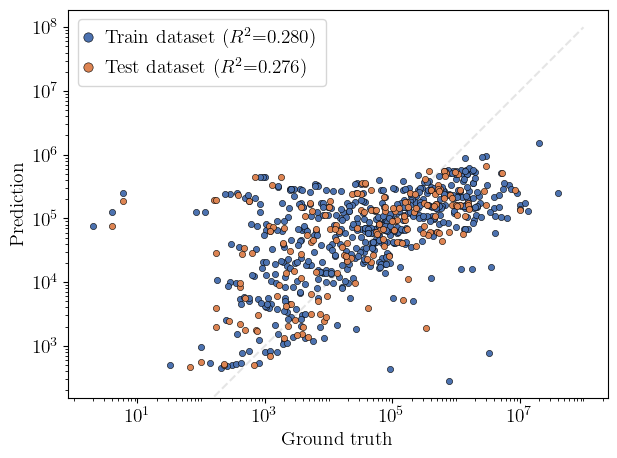

In [8]:
plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

sv = svm.SVR()
plot_truth_pred_sklearn(feature_data, label_data, train_dataset.indices, test_dataset.indices, ax, model = sv, split_by = split_by)

plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig(f'../output/{project}/sv_truth_pred.svg')
if is_notebook():
    plt.show()
plt.close()

## Permutation feature importance

In [9]:
def forward_func(data):
    prediction, ground_truth, loss = test_tensor(data, y[test_dataset.indices,:], model, loss_fn)
    return loss

feature_perm = FeaturePermutation(forward_func)
attr = feature_perm.attribute(X[test_dataset.indices,:]).cpu().numpy()[0]

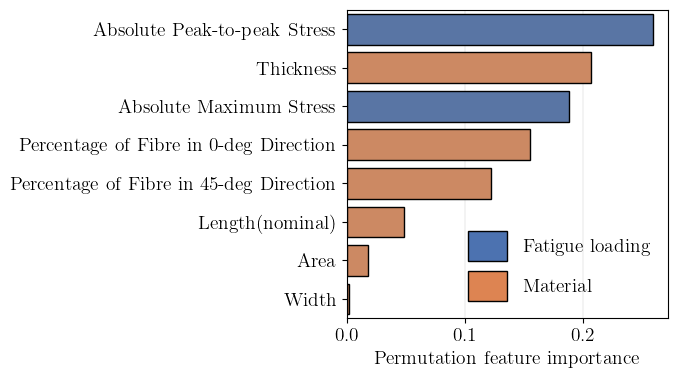

In [10]:
clr = sns.color_palette('deep')

pal = [clr[args['feature_names_type'][x]] for x in feature_names]

clr_map = dict()
for idx, feature_type in enumerate(args['feature_types']):
    clr_map[feature_type] = clr[idx]

plt.figure(figsize=(7,4))
ax = plt.subplot(111)
plot_importance(ax, feature_names, attr, pal = pal, clr_map = clr_map, linewidth=1, edgecolor='k', orient='h')
plt.tight_layout()

plt.savefig(f'../output/{project}/feature_importance.png', dpi=600)
# plt.close()
if is_notebook():
    plt.show()
plt.close()

## Partial dependence

Calculate PDP:  Width
Calculate PDP:  Area
Calculate PDP:  Percentage of Fibre in 45-deg Direction
Calculate PDP:  Percentage of Fibre in 0-deg Direction
Calculate PDP:  Length(nominal)
Calculate PDP:  Absolute Maximum Stress
Calculate PDP:  Absolute Peak-to-peak Stress
Calculate PDP:  Thickness
(14, 6) 4 2


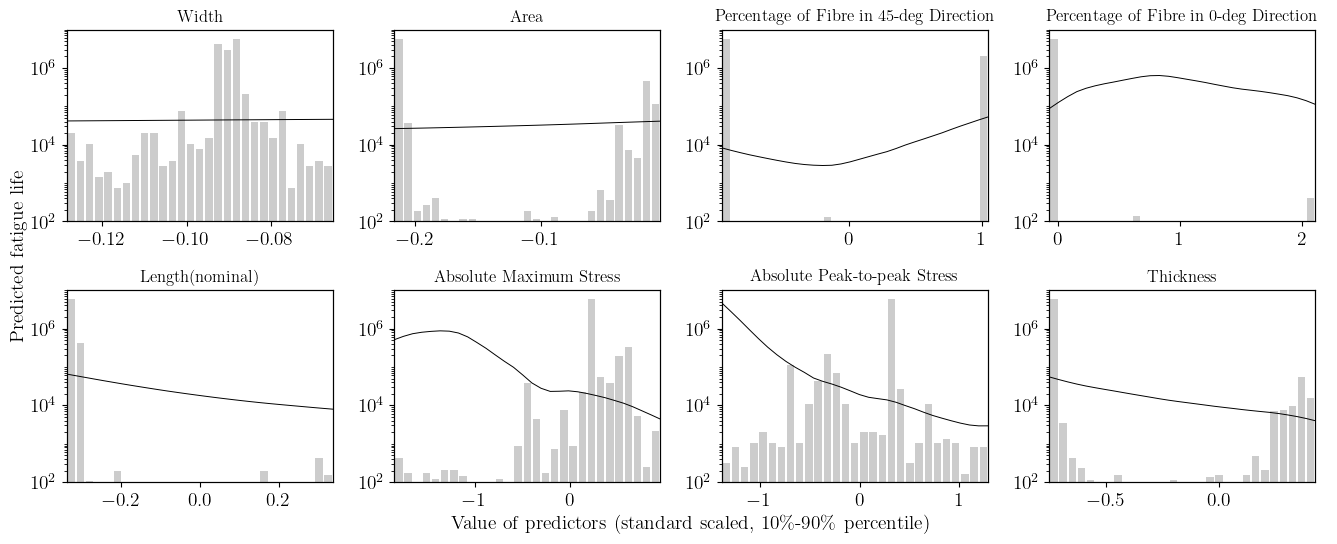

In [11]:
x_values_list = []
mean_pdp_list = []


for feature_idx in range(len(feature_names)):
    print('Calculate PDP: ',feature_names[feature_idx])
    
    pdp_list = []
    ci_left = []
    ci_right = []
    x_value, model_predictions = calculate_pdp(model,X[train_dataset.indices,:],feature_idx,grid_size=30)
    
    x_values_list.append(x_value)
    mean_pdp_list.append(model_predictions)

fig=plot_pdp(feature_names, x_values_list, mean_pdp_list, X, train_dataset.indices)

plt.savefig(f'../output/{project}/partial_dependence.svg')
if is_notebook():
    plt.show()
plt.close()